<a href="https://colab.research.google.com/github/lw-miles24/CompModNervSys-final/blob/main/simulate_BallAndStick_firing_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize session

Install neuron as usual.

In [2]:
%pip install neuron # only need to run this cell once to install
                    # neuron in the local jupyter environment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 23.8 MB/s eta 0:00:00


Mount the rest of the model files from the github repository.

In [3]:
repo_name = 'CompModNervSys-final'
if 'google.colab' in str(get_ipython()):
    import os
    if not os.path.exists(repo_name):
        !git clone https://github.com/lw-miles24/{repo_name}.git # downloads repository into our Google colab session's file system

    os.chdir(repo_name) # Changing working directory to downloaded repository

# Compile mechanisms
!nrnivmodl mechanisms

Cloning into 'CompModNervSys-final'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 83 (delta 33), reused 41 (delta 13), pack-reused 0
Receiving objects: 100% (83/83), 492.87 KiB | 14.50 MiB/s, done.
Resolving deltas: 100% (33/33), done.
/content/CompModNervSys-final
Mod files: "mechanisms/mechanisms/kv.mod" "mechanisms/mechanisms/na.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../mechanisms/kv.mod
 -> NMODL ../mechanisms/na.mod
Translating kv.mod into /content/CompModNervSys-final/x86_64/kv.c
Translating na.mod into /content/CompModNervSys-final/x86_64/na.c
Thread Safe
Thread Safe
 -> Compiling kv.c
 -> Compiling na.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special


Import the packages we'll be using.

In [4]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary
import numpy as np
import matplotlib.pyplot as plt
import plotly
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    output.enable_custom_widget_manager()


# Dendritic AIS model

Create the Ball and Stick neuron model

In [5]:
from ballandstick import BallAndStick

ais_mode = 'dend' # set to either 'soma' or 'dend'
ais_loc = 0.028 # if ais_mode is 'dend', sets how far along the basal dendrite to attach the AIS
               # benchmark values from Hodapp et al. 2022, ranging 0 to 1 (along 200 µm basal dendrite)
               # mean axonal distance: 0.028 (5.7 µm)
               # 95th percentile:      0.06   (12 µm)
cell_dAIS = BallAndStick(0,ais_mode,ais_loc)

h.topology()
# Time vector
t_vec = h.Vector().record(h._ref_t)
# Simulation parameter settings
h.celsius = 37 # degC
h.steps_per_ms = 1/0.025
h.dt = 0.025 # ms
h.tstop = 20 # ms
h.v_init = -69 # mV

# Stimulation
iclamp = h.IClamp(cell_dAIS.soma(0.5))
iclamp.delay = 0 # ms
iclamp.dur = h.tstop # ms
iclamp.amp = 1 # ms
iclamp_i = h.Vector().record(iclamp._ref_i)


|-----|       BallAndStick[0].soma(0-1)
       `--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|       BallAndStick[0].dend[0](0-1)
             `--------------------|       BallAndStick[0].ais_prox(0-1)
                                   `--------------------|       BallAndStick[0].ais_dist(0-1)
                                                         `------------------------|       BallAndStick[0].axon(0-1)
       `----------|       BallAndStick[0].dend[1](0-1)
    `--------------------|       BallAndStick[0].apic[0](0-1)
                          `----|       BallAndStick[0].apic[1](0-1)
                          `----|       BallAndStick[0].apic[2](0-1)



Add excitatory synapse to basal dendritic branch with AIS (`dend[0]`), distal to AIS. Add inhibitory synapse to soma.

In [6]:
# Add excitatory synapse to basal dendrite
exc_syn_loc = 0.438 # 0 to 1, sets how far along basal dendrite excitatory synapse is added
                    # 0.438 = 87.6 µm along 200 µm basal dendrite (average stim
                    # location used in Hodapp et al. 2022 simulations)
exc_syn = h.Exp2Syn(cell_dAIS.dend[0](exc_syn_loc))
exc_syn.tau1 = 0.175 # ms - rise time (taken from Hodapp 2022 supp materials)
exc_syn.tau2 = 5 # ms - decay time
exc_syn.e = 0 # mV - eversal potential

# Add inhibitory synapse to soma
inh_syn = h.Exp2Syn(cell_dAIS.soma(0.5))
inh_syn.tau1 = 1.6 # ms
inh_syn.tau2 = 11 # ms
inh_syn.e = -75 # mV

# synaptic current recordings
exc_syn_i = h.Vector().record(exc_syn._ref_i)
exc_syn_g = h.Vector().record(exc_syn._ref_g)
inh_syn_i = h.Vector().record(inh_syn._ref_i)
inh_syn_g = h.Vector().record(inh_syn._ref_g)

Make `NetStim`s to drive synapses and `NetCons` to connect `NetStim`s to the synapses.  

In [60]:
# NetStim to simulate excitatory presynaptic spikes
estim = h.NetStim()
estim.number = 1
estim.interval = 10 # ms - interval between spikes
estim.start = 5 # ms
estim.noise = 0

# NetCon to connect excitatory presynaptic spikes to excitatory postsynaptic conductance
nc_estim = h.NetCon(estim,exc_syn)
nc_estim.delay = 1 # ms - synaptic delay
nc_estim.weight[0] = 1 # µS - peak conductance

# NetStim to simulate inhibitory presynaptic spikes
istim = h.NetStim()
istim.number = 1
istim.interval = 10 # ms - interval between spikes
istim.start = 5 # ms
istim.noise = 0

# NetCon to connect inhibitory presynaptic spikes to excitatory postsynaptic conductance
nc_istim = h.NetCon(istim,inh_syn)
nc_istim.delay = 1 # ms - synaptic delay
nc_istim.weight[0] = 1 # µS - peak conductance

**Opt. 1** Define helper function to detect if the cell fired an AP. If it did, also determine at what voltage threshold this occurred.

**Opt. 2** Define helper function to detect if the cell fired an AP, checking if it happened in the soma & AIS (1.0) vs. AIS only (0.5) vs. neither (0).

In [129]:
def get_spike_times(v_vec_AIS,t_vec,threshold=0):
    spike_times = []
    firing = False
    for i in np.arange(0,len(t_vec)):
        if v_vec_AIS[i] > threshold:
            if not firing:
                firing = True
                spike_times.append(t_vec[i])
        if firing and v_vec_AIS[i] < threshold:
            firing = False
    return np.array(spike_times)

def hz_out(spike_times):
    if len(spike_times) < 2:
        return False,0
    burst_duration = (spike_times[-1] - spike_times[0])*1e-3 # burst duration in s
    hz = (len(spike_times)-1)/burst_duration
    return True,hz

In [134]:
nc_estim.weight[0] = 0.0
nc_istim.weight[0] = 0.0
curr_range = np.linspace(0,20,21)

hz_list = []
for i in np.arange(0,len(curr_range)):
    iclamp.amp = curr_range[i] # nA
    h.run()
    spike_times = get_spike_times(cell_dAIS.ais_v,t_vec)
    did_burst,hz = hz_out(spike_times)
    hz_list.append(hz)

Text(0, 0.5, 'frequency (Hz)')

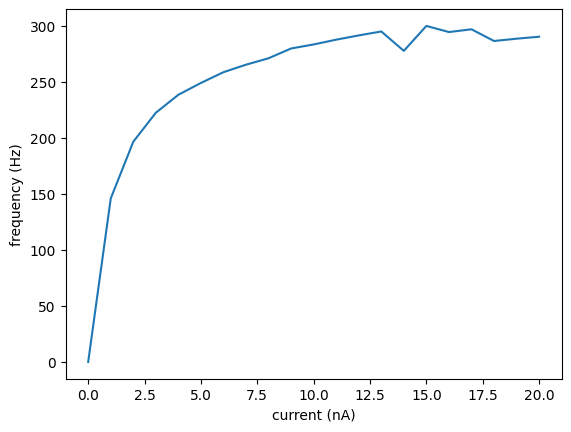

In [133]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(curr_range,hz_list)
ax.set_xlabel('current (nA)')
ax.set_ylabel('frequency (Hz)')

In [151]:
iclamp.amp = 0.5 # nA - with estim/istim weights at 0, 0.3 nA gives ~80 Hz firing rate baseline
exc_range = np.linspace(0,0.12,5) #13
inh_range = np.linspace(0,0.08,9) #9

dAIS_fire_matrix = np.zeros((len(exc_range),len(inh_range)))

for e in np.arange(0,len(exc_range)):
    for i in np.arange(0,len(inh_range)):
        nc_estim.weight[0] = exc_range[e]
        nc_istim.weight[0] = inh_range[i]
        h.run()
        spike_times = get_spike_times(cell_dAIS.ais_v,t_vec)
        did_burst,hz = hz_out(spike_times)
        if did_burst:
            dAIS_fire_matrix[e,i] = hz
        else:
            dAIS_fire_matrix[e,i] = np.nan

In [152]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(z=dAIS_fire_matrix,x=inh_range*1e3,y=exc_range*1e3))
fig.update_xaxes(title_text="Inhibitory weight (nS)")
fig.update_yaxes(title_text="Excitatory weight (nS)")
fig.update_traces(colorbar_title_text='firing frequency (Hz)',colorbar_title_side='right',selector=dict(type='heatmap'))
fig.show()

# Somatic AIS model

Create the Ball and Stick neuron model

In [4]:
from ballandstick import BallAndStick

ais_mode = 'soma' # set to either 'soma' or 'dend'
ais_loc = 0 # if ais_mode is 'dend', sets how far along the basal dendrite to attach the AIS
               # 0.06 = 12 µm along the 200 µm basal dendrite (95th percentile in Hodapp et al. 2022)
cell_sAIS = BallAndStick(0,ais_mode,ais_loc)

h.topology()
# Time vector
t_vec = h.Vector().record(h._ref_t)
# Simulation parameter settings
h.celsius = 37 # degC
h.steps_per_ms = 1/0.025
h.dt = 0.025 # ms
h.tstop = 20 # ms
h.v_init = -69 # mV

# Stimulation
iclamp = h.IClamp(cell_sAIS.soma(0.5))
iclamp.delay = 0 # ms
iclamp.dur = 20 # ms
iclamp.amp = 1 # nA
iclamp_i = h.Vector().record(iclamp._ref_i)


|-----|       BallAndStick[0].soma(0-1)
       `--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|       BallAndStick[0].dend[0](0-1)
       `----------|       BallAndStick[0].dend[1](0-1)
       `--------------------|       BallAndStick[0].ais_prox(0-1)
                             `--------------------|       BallAndStick[0].ais_dist(0-1)
                                                   `------------------------|       BallAndStick[0].axon(0-1)
    `--------------------|       BallAndStick[0].apic[0](0-1)
                          `----|       BallAndStick[0].apic[1](0-1)
                          `----|       BallAndStick[0].apic[2](0-1)



Add excitatory synapse to basal dendritic branch with AIS (`dend[0]`), distal to AIS. Add inhibitory synapse to soma.

In [5]:
# Add excitatory synapse to basal dendrite
exc_syn_loc = 0.438 # 0 to 1, sets how far along basal dendrite excitatory synapse is added
                    # 0.438 = 87.6 µm along 200 µm basal dendrite (average stim
                    # location used in Hodapp et al. 2022 simulations)
exc_syn = h.Exp2Syn(cell_sAIS.dend[0](exc_syn_loc))
exc_syn.tau1 = 0.175 # ms - rise time (taken from Hodapp 2022 supp materials)
exc_syn.tau2 = 5 # ms - decay time
exc_syn.e = 0 # mV - eversal potential

# Add inhibitory synapse to soma
inh_syn = h.Exp2Syn(cell_sAIS.soma(0.5))
inh_syn.tau1 = 1.6 # ms
inh_syn.tau2 = 11 # ms
inh_syn.e = -75 # mV

# synaptic current recordings
exc_syn_i = h.Vector().record(exc_syn._ref_i)
exc_syn_g = h.Vector().record(exc_syn._ref_g)
inh_syn_i = h.Vector().record(inh_syn._ref_i)
inh_syn_g = h.Vector().record(inh_syn._ref_g)

Make `NetStim`s to drive synapses and `NetCons` to connect `NetStim`s to the synapses.  

In [6]:
# NetStim to simulate excitatory presynaptic spikes
estim = h.NetStim()
estim.number = 1
estim.interval = 10 # ms - interval between spikes
estim.start = 5 # ms
estim.noise = 0

# NetCon to connect excitatory presynaptic spikes to excitatory postsynaptic conductance
nc_estim = h.NetCon(estim,exc_syn)
nc_estim.delay = 1 # ms - synaptic delay
nc_estim.weight[0] = 1 # µS - peak conductance

# NetStim to simulate inhibitory presynaptic spikes
istim = h.NetStim()
istim.number = 1
istim.interval = 10 # ms - interval between spikes
istim.start = 5 # ms
istim.noise = 0

# NetCon to connect inhibitory presynaptic spikes to excitatory postsynaptic conductance
nc_istim = h.NetCon(istim,inh_syn)
nc_istim.delay = 1 # ms - synaptic delay
nc_istim.weight[0] = 1 # µS - peak conductance

**Opt. 1** Define helper function to detect if the cell fired an AP. If it did, also determine at what voltage threshold this occurred.

**Opt. 2** Define helper function to detect if the cell fired an AP, checking if it happened in the soma & AIS (1.0) vs. AIS only (0.5) vs. neither (0).

In [62]:
def get_spike_times(v_vec_AIS,t_vec,threshold=0):
    spike_times = []
    firing = False
    for i in np.arange(0,len(t_vec)):
        if v_vec_AIS[i] > threshold:
            if not firing:
                firing = True
                spike_times.append(t_vec[i])
        if firing and v_vec_AIS[i] < threshold:
            firing = False
    return np.array(spike_times)

def hz_out(spike_times):
    if len(spike_times) < 2:
        return False,0
    burst_duration = (spike_times[-1] - spike_times[0])*1e-3 # burst duration in s
    hz = (len(spike_times)-1)/burst_duration
    return True,hz

Simulate a range of excitatory and inhibitory weights from Hodapp et al. 2022.

In [1]:
exc_range = np.linspace(0,0.12,5) #13
inh_range = np.linspace(0,0.08,9) #9
iclamp.amp = 5 # nA

sAIS_fire_matrix = np.zeros((len(exc_range),len(inh_range)))

for e in np.arange(0,len(exc_range)):
    for i in np.arange(0,len(inh_range)):
        nc_estim.weight[0] = exc_range[e]
        nc_istim.weight[0] = inh_range[i]
        h.run()
        did_burst,hz = hz_out(get_spike_times(cell_sAIS.ais_v,t_vec))
        if did_burst:
            sAIS_fire_matrix[e,i] = hz
        else:
            sAIS_fire_matrix[e,i] = np.nan


NameError: name 'np' is not defined

Plot on heatmap.

In [44]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(z=sAIS_fire_matrix,x=inh_range*1e3,y=exc_range*1e3))
fig.update_xaxes(title_text="Inhibitory weight (nS)")
fig.update_yaxes(title_text="Excitatory weight (nS)")
fig.update_traces(colorbar_title_text='firing rate (Hz)',colorbar_title_side='right',selector=dict(type='heatmap'))
fig.show()

Get Hz out for a range of current clamps

In [56]:
nc_estim.weight[0] = 0
nc_istim.weight[0] = 0
curr_range = np.linspace(0,20,21)

hz_list = []
for i in np.arange(0,len(curr_range)):
    iclamp.amp = curr_range[i] # nA
    h.run()
    spike_times = get_spike_times(cell_sAIS.ais_v,t_vec)
    did_burst,hz = hz_out(spike_times)
    hz_list.append(hz)

Text(0, 0.5, 'frequency (Hz)')

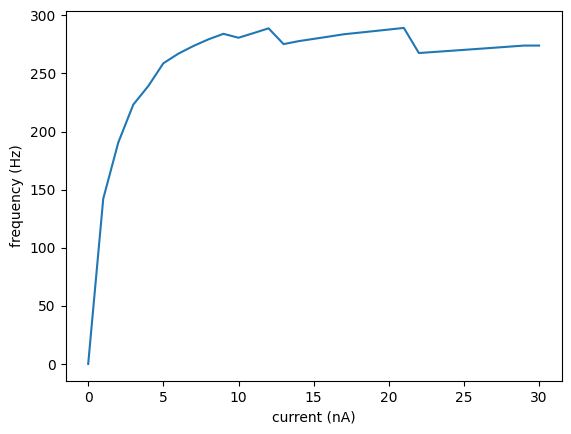

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(curr_range,hz_list)
ax.set_xlabel('current (nA)')
ax.set_ylabel('frequency (Hz)')